# 1. Importing Libraries and data loading

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



import re
import string
import unicodedata


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from collections import Counter

from wordcloud import WordCloud

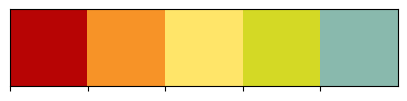

In [197]:
# custom color palette
my_colors = ["#B70404", "#F79327", "#FFE569", "#D4D925", "#89B9AD"]  

# Plot Color Palletes
sns.palplot(my_colors)

In [198]:
# Download the necessary NLTK data
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [199]:
# read the dataset into a dataframe
df = pd.read_csv('D:\Cyberbullying classification\data\cyberbullying_data.csv')
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
39804,"Black ppl aren't expected to do anything, depe...",ethnicity
39805,Turner did not withhold his disappointment. Tu...,ethnicity
39806,I swear to God. This dumb nigger bitch. I have...,ethnicity
39807,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


# 2. Data Cleaning & eda

## 2.1 Cleaning tweet text

In [200]:
# Contractions dictionary
CONTRACTIONS_DICT = {
    "can't": "can not",
    "n't": " not",  # catches don't -> do not, isn't -> is not, etc.
    "n’t": " not", # (curly apostrophe)
    "'re": " are",  # catches you're -> you are, they're -> they are, etc.
    "’re": " are", # (curly apostrophe)
    "'s": " is",  # catches she's -> she is, he's -> he is, etc.
    "’s": " is", # (curly apostrophe)
    "'d": " would",  # catches I'd -> I would, you'd -> you would, etc.
    "’d": " would", # I’d -> I would (curly apostrophe)
    "'ll": " will",  # catches I'll -> I will, you'll -> you will, etc.
    "’ll": " will", # I’ll -> I will (curly apostrophe)
    "'ve": " have",  # catches I've -> I have, you've -> you have, etc.
    "’ve": " have", # I’ve -> I have (curly apostrophe)
    "'m": " am",  # catches I'm -> I am
    "’m": " am",    # I’m -> I am (curly apostrophe)
    "y'all": " you all", # y'all -> you all
    "y’all": "you all"  # y’all -> you all (curly apostrophe)
}

def expand_contractions(text, contractions_dict=CONTRACTIONS_DICT):
    """
    Expand contractions in the text using the provided contractions dictionary.
    
    Parameters:
    text (str): The input text.
    contractions_dict (dict): Dictionary of contractions and their expanded forms.
    
    Returns:
    str: Text with expanded contractions.
    """
    # Replace contractions using regex to identify patterns in the text
    for contraction, expansion in contractions_dict.items():
        pattern = re.compile(re.escape(contraction), re.IGNORECASE)
        text = pattern.sub(expansion, text)
    
    return text

SLANG_MISSPELLED_DICT = {
    "u": "you",
    "ur": "your",
    "r": "are",
    "gr8": "great",
    "luv": "love",
    "plz": "please",
    "thx": "thanks",
    "b4": "before",
    "thru": "through",
    "wat": "what",
    "cuz": "because",
    "bcuz": "because",
    "btw": "by the way",
    "gonna": "going to",
    "wanna": "want to",
    "l8": "late",
    "ne1": "anyone",
    "omg": "oh my god",
    "lol": "laughing out loud",
    "sry": "sorry",
    "ttyl": "talk to you later",
    "smh": "shaking my head",
    "c u": "see you",
    "yr": "your",
    "k": "ok",
    "nvm": "never mind",
    "gd": "good",
    "txt": "text",
    "frm": "from",
    "gd nite": "good night",
    "w/": "with",
    "lmao": "laughing my ass off",
    "prolly": "probably",
    "fav": "favorite",
    "fam": "family",
    "lit": "exciting",
    "dont": "do not",
    "didnt": "did not",
    "cant": "can not"
}

def correct_misspellings(text, slang_misspelled_dict= SLANG_MISSPELLED_DICT):
    """
    Correct common misspelled words in a given text using a predefined dictionary.
    
    Args:
    text (str): The input text to be corrected.
    misspelled_dict (dict): A dictionary of common misspellings and their corrections.

    Returns:
    str: The corrected text.
    """
    # Create a regex pattern for each word to match, considering word boundaries
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in slang_misspelled_dict.keys()) + r')\b', re.IGNORECASE)

    # Replace each slang/misspelled word with its corrected form
    corrected_text = pattern.sub(lambda x: slang_misspelled_dict[x.group().lower()], text)
    return corrected_text

def clean_hashtags(text):
    # Remove hashtags at the end of the sentence
    text = re.sub(r'(\s+#[\w-]+)+\s*$', '', text).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    text = re.sub(r'#([\w-]+)', r'\1', text).strip()
    
    return text

# Remove accented character
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_patterns(text):
    """
    Remove various unwanted patterns from the text such as emails, URLs, mentions, etc.
    
    Parameters:
    text (str): The input text.
    
    Returns:
    str: Text with removed patterns.
    """

    # Remove emails
    text = re.sub(r'\S+@\S+\.\S+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Removing RT and QT
    text = re.sub(r'(\brt\b|\bqt\b)', '', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    def clean_hashtags(text):
        # Remove hashtags at the end of the sentence
        text = re.sub(r'(\s+#[\w-]+)+\s*$', '', text).strip()
    
        # Remove the # symbol from hashtags in the middle of the sentence
        text = re.sub(r'#([\w-]+)', r'\1', text).strip()
    
        return text
    
    text = clean_hashtags(text)

    # Remove Unicode-based emojis
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
    text = re.sub(emoji_pattern, '', text)

    # Remove traditional keyboard-based emoticons
    emoticon_pattern = r"(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)"
    text = re.sub(emoticon_pattern, '', text)

    # Reduce elongated characters (e.g., "cooool" -> "cool")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Replace ".." or "..." with a space
    text = re.sub(r'\.{2,}', ' ', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove spaces between single characters
    text = re.sub(r'(?<=\b\w)\s(?=\w\b)', '', text)

    # Remove extra whitespace
    text = text.strip()
    
    return text

def remove_stopwords(text):
    """
    Remove stopwords from the text.
    
    Parameters:
    text (str): The input text.
    
    Returns:
    str: Text without stopwords.
    """
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

def tokenize_and_lemmatize(text):
    """
    Tokenize and lemmatize the text.
    
    Parameters:
    text (str): The input text.
    
    Returns:
    str: Lemmatized text.
    """
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)



def clean_tweet(text):
    """
    Perform all cleaning steps on the tweet text.
    
    Parameters:
    text (str): The tweet text to be cleaned.
    
    Returns:
    str: The cleaned tweet text.
    """
    text = text.lower()
    text = expand_contractions(text)
    text = correct_misspellings(text)
    text = remove_accented_chars(text)
    text = remove_patterns(text)
    text = remove_stopwords(text)
    text = tokenize_and_lemmatize(text)
    return text

In [201]:
# Apply the cleaning function to the 'tweet_text' column
df['text_cleaned'] = df['tweet_text'].apply(clean_tweet)

In [202]:
df['text_cleaned'].head(5)

0                   word katandandre food crapilicious
1                                       aussietv white
2                      classy whore red velvet cupcake
3    meh thanks head concerned another angry dude t...
4    isi account pretending kurdish account like is...
Name: text_cleaned, dtype: object

## 2.2 Tweet text length after data cleaning

In [203]:
# Length of the tweet text after cleaning
df['text_cleaned_length'] = df['text_cleaned'].apply(len)

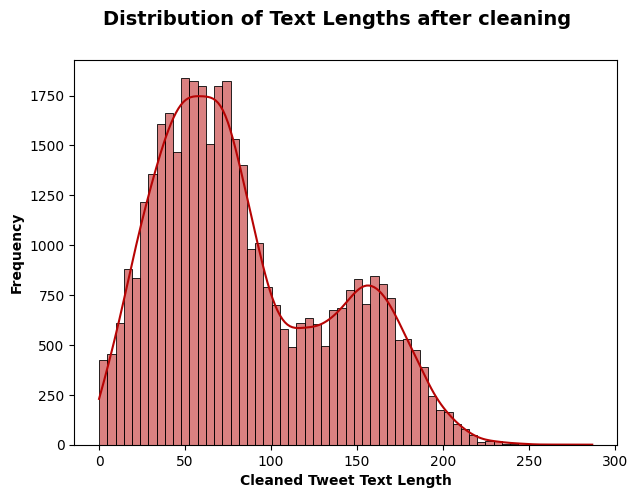

In [204]:
# Plot the distribution of text lengths after cleaning
plt.figure(figsize=(7, 5))
sns.histplot(df['text_cleaned_length'], bins=60, color= my_colors[0], kde=True)
plt.xlabel('Cleaned Tweet Text Length', fontweight = 'heavy', fontsize = 10)
plt.ylabel('Frequency', fontweight = 'heavy', fontsize = 10)
plt.suptitle('Distribution of Text Lengths after cleaning', 
             fontweight = 'heavy', fontsize = 14)
plt.show()

## 2.3 Word Count Distribution

In [205]:
# calculating word count of cleaned tweet text
df['text_cleaned_word_count'] = [len(text.split()) for text in df.text_cleaned]

# Generate summary statistics
print(df['text_cleaned_word_count'].describe())

count    39809.000000
mean        13.408626
std          7.602878
min          0.000000
25%          8.000000
50%         12.000000
75%         19.000000
max         43.000000
Name: text_cleaned_word_count, dtype: float64


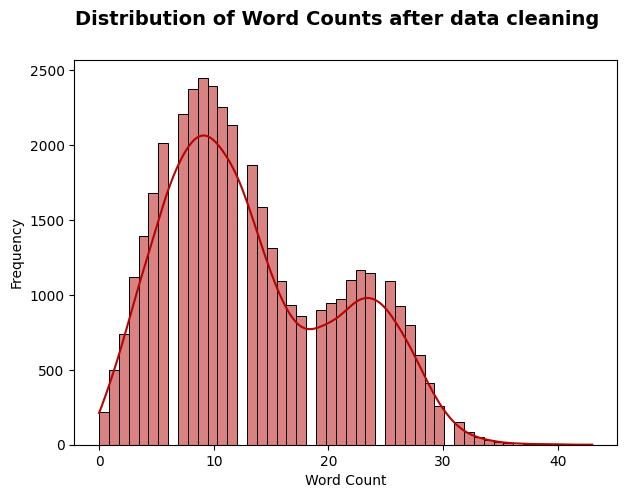

In [206]:
# Plot a histogram of word count
plt.figure(figsize=(7, 5))
sns.histplot(df['text_cleaned_word_count'], bins=50, color= my_colors[0], kde=True)
plt.suptitle('Distribution of Word Counts after data cleaning', 
             fontweight = 'heavy', fontsize = 14)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## 2.4 Analyze Word Count by Category

We can analyze word count by category to see if there are any notable differences.

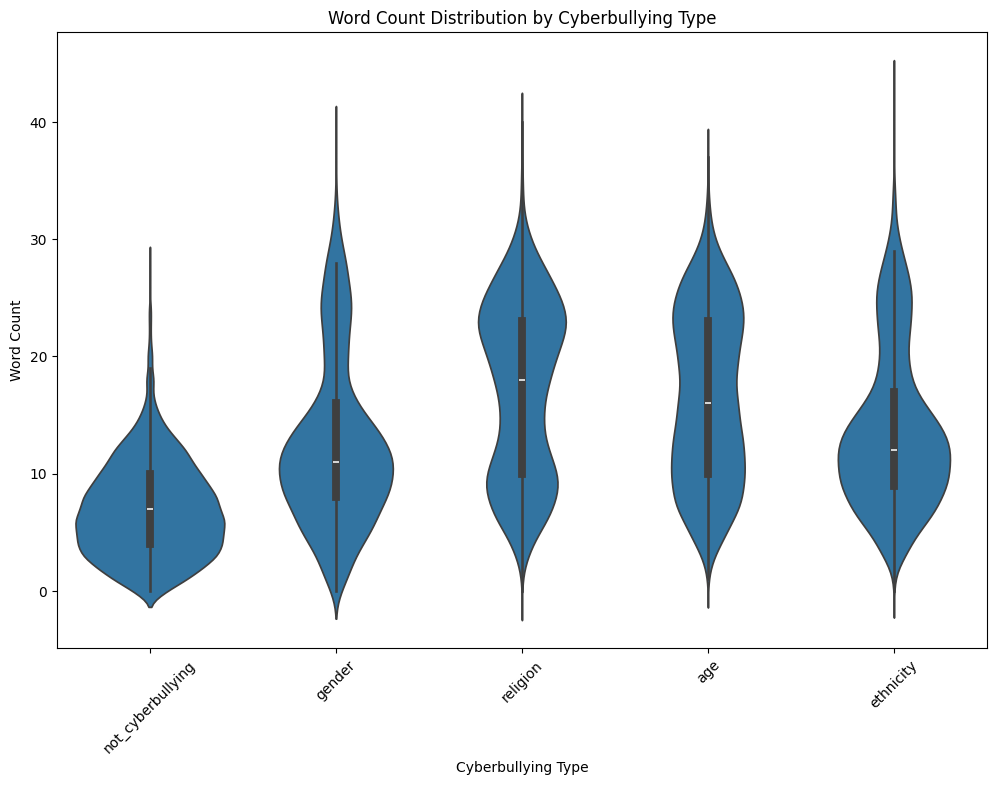

In [207]:
# Box plot of word count by cyberbullying type
plt.figure(figsize=(12, 8))
sns.violinplot(x='cyberbullying_type', y='text_cleaned_word_count', data=df)
plt.title('Word Count Distribution by Cyberbullying Type')
plt.xlabel('Cyberbullying Type')
plt.ylabel('Word Count')
plt.xticks(rotation=45)
plt.show()

## 2.5 Analyze tweet texts that are short

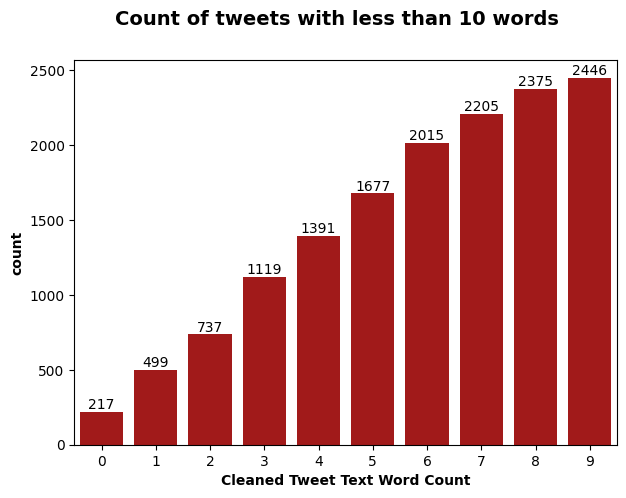

In [208]:
# count plot of tweets with less than 10 words
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_cleaned_word_count', data=df[df['text_cleaned_word_count']<10], color= my_colors[0])
plt.suptitle('Count of tweets with less than 10 words', fontweight = 'heavy', fontsize = 14)
ax.bar_label(ax.containers[0])
plt.ylabel('count', fontweight = 'heavy')
plt.xlabel('Cleaned Tweet Text Word Count', fontweight = 'heavy')
plt.show()

## 2.6 Delete rows containing tweets with fewer than 3 words

In [209]:
# Filter the DataFrame to get rows with fewer than 3 words in the cleaned tweets
short_tweets_df = df[df['text_cleaned_word_count'] <= 3]

# Loop through each tweet in long_tweets and print it
print("\nTweets with less than 3 words:")
for index, row in short_tweets_df.iterrows():
    print(f"Tweet {index + 1} (Length: {row['text_cleaned_word_count']}):\n{row['text_cleaned']}\n")
    print(f"Cyberbullying type: {row['cyberbullying_type']}")
    print("\n" + "-"*50 + "\n")


Tweets with less than 3 words:
Tweet 2 (Length: 2):
aussietv white

Cyberbullying type: not_cyberbullying

--------------------------------------------------

Tweet 9 (Length: 3):
everything mostly priest

Cyberbullying type: not_cyberbullying

--------------------------------------------------

Tweet 11 (Length: 0):


Cyberbullying type: not_cyberbullying

--------------------------------------------------

Tweet 12 (Length: 3):
bully flush kd

Cyberbullying type: not_cyberbullying

--------------------------------------------------

Tweet 13 (Length: 1):
ughh

Cyberbullying type: not_cyberbullying

--------------------------------------------------

Tweet 27 (Length: 3):
isso e bullying

Cyberbullying type: not_cyberbullying

--------------------------------------------------

Tweet 32 (Length: 0):


Cyberbullying type: not_cyberbullying

--------------------------------------------------

Tweet 40 (Length: 1):
fuck

Cyberbullying type: not_cyberbullying

---------------------------

In [210]:
# Filter the DataFrame to keep rows with 3 or more words in the cleaned tweets
df = df[df['text_cleaned_word_count'] > 3].reset_index(drop=True)

# Check the shape to see how many rows are remaining after the removal
print(f"Number of rows after removing tweets with fewer than 3 words: {df.shape[0]}")

Number of rows after removing tweets with fewer than 3 words: 37237


## 2.7 Are there duplicate tweets after the cleaning?

In [211]:
print(f'There are around {int(df["text_cleaned"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 662 duplicated tweets, we will remove them.


In [212]:
# Check for duplicated rows based on all columns
duplicates = df["text_cleaned"].duplicated()

# Display the number of duplicated rows
print(f"\nNumber of duplicated rows: {duplicates.sum()}")


Number of duplicated rows: 662


In [213]:
# Remove duplicated rows and keep the first occurrence
df = df.drop_duplicates()
print(f"\nNumber of duplicated rows: {df.duplicated().sum()}")
print(df.shape)


Number of duplicated rows: 0
(37237, 5)


# 3. More EDA

## 3.1 Looking at class distribution 

In [214]:
class_counts_cleaned = df['cyberbullying_type'].value_counts()
print(class_counts_cleaned)

cyberbullying_type
religion             7910
age                  7908
ethnicity            7791
gender               7443
not_cyberbullying    6185
Name: count, dtype: int64


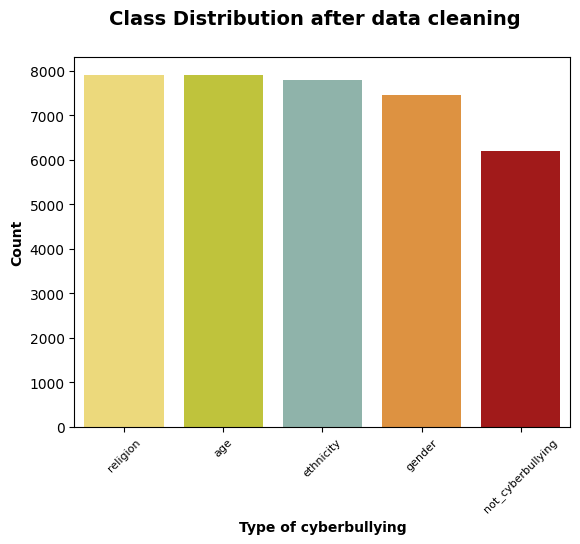

In [215]:
# plot the class distribution
sns.countplot(data=df, x=df["cyberbullying_type"], hue="cyberbullying_type", palette=my_colors, order=class_counts_cleaned.index)
plt.suptitle('Class Distribution after data cleaning', 
             fontweight = 'heavy', fontsize = 14)
plt.xlabel('Type of cyberbullying', fontweight = 'heavy', fontsize = 10)
plt.ylabel('Count', fontweight = 'heavy', fontsize = 10)
# Adjust the x-axis labels
plt.xticks(fontsize=8, rotation=45) 
plt.show()

Looking at the class distribution, we can see that, there are difference in class sizes.

## 3.2 Word Clouds and N-grams

In [216]:
religion = df[df.cyberbullying_type=="religion"]["text_cleaned"].values
age = df[df.cyberbullying_type=="age"]["text_cleaned"].values
ethnicity = df[df.cyberbullying_type=="ethnicity"]["text_cleaned"].values
gender = df[df.cyberbullying_type=="gender"]["text_cleaned"].values
not_cyberbullying = df[df.cyberbullying_type=="not_cyberbullying"]["text_cleaned"].values

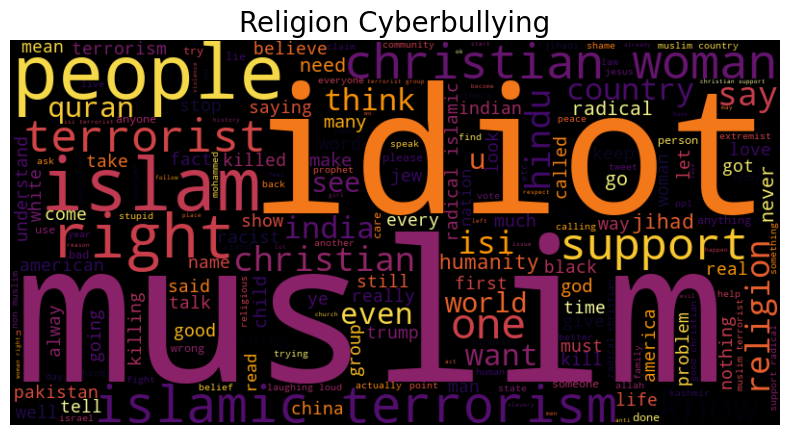

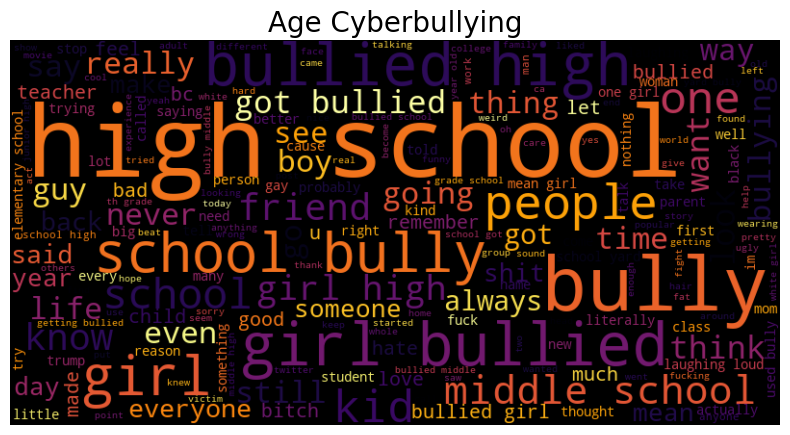

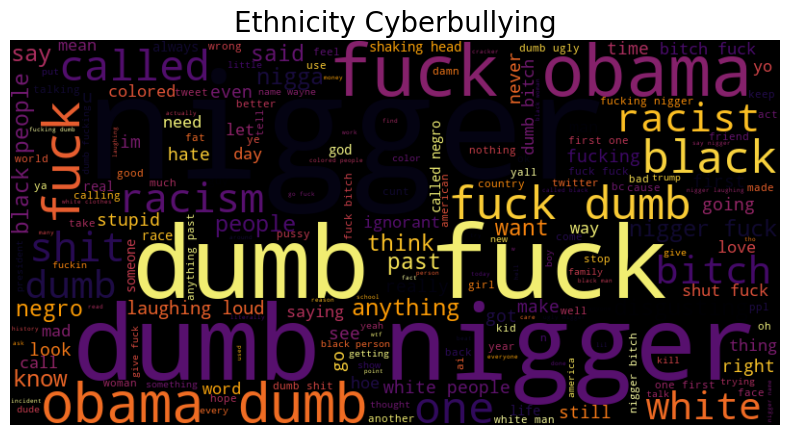

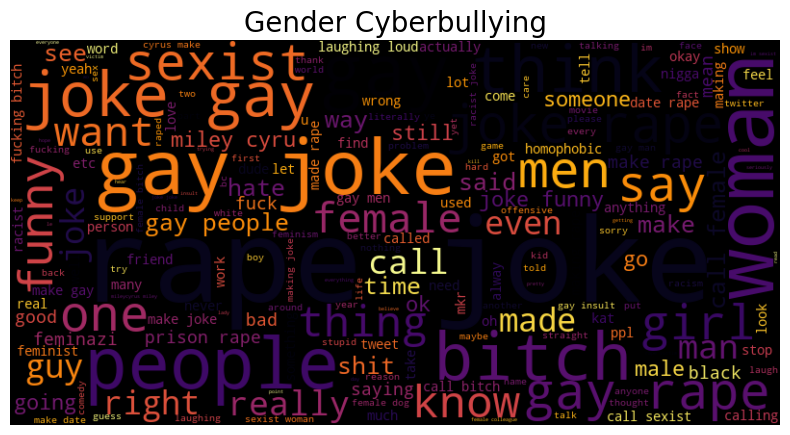

In [217]:
# Function to generate and display a word cloud
def generate_wordcloud(text, title=None):
    wordcloud = WordCloud(width=800, height=400, colormap='inferno', background_color='black').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=20)
    plt.show()

# Generate word clouds for each cyberbullying type
generate_wordcloud(religion, title="Religion Cyberbullying")
generate_wordcloud(age, title="Age Cyberbullying")
generate_wordcloud(ethnicity, title="Ethnicity Cyberbullying")
generate_wordcloud(gender, title="Gender Cyberbullying")

In [218]:
# Function to generate n-grams
def generate_ngrams(text, n=2):
    n_grams = ngrams(text.split(), n)
    return [' '.join(grams) for grams in n_grams]

# Example: Generate bigrams and trigrams
religion_bigrams = Counter([gram for text in religion for gram in generate_ngrams(text, 2)])
age_bigrams = Counter([gram for text in age for gram in generate_ngrams(text, 2)])
ethnicity_bigrams = Counter([gram for text in ethnicity for gram in generate_ngrams(text, 2)])
gender_bigrams = Counter([gram for text in gender for gram in generate_ngrams(text, 2)])
not_cyberbullying_bigrams = Counter([gram for text in not_cyberbullying for gram in generate_ngrams(text, 2)])

# Example for trigrams
religion_trigrams = Counter([gram for text in religion for gram in generate_ngrams(text, 3)])
age_trigrams = Counter([gram for text in age for gram in generate_ngrams(text, 3)])
ethnicity_trigrams = Counter([gram for text in ethnicity for gram in generate_ngrams(text, 3)])
gender_trigrams = Counter([gram for text in gender for gram in generate_ngrams(text, 3)])
not_cyberbullying_trigrams = Counter([gram for text in not_cyberbullying for gram in generate_ngrams(text, 3)])

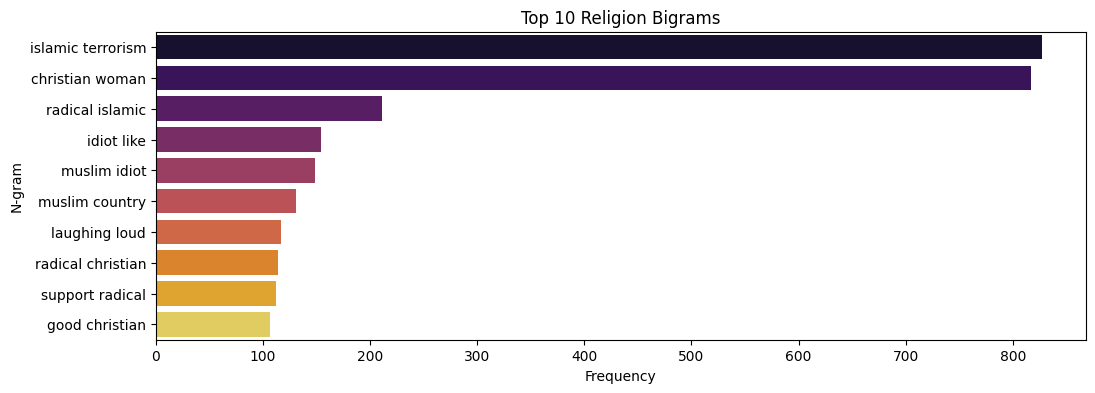

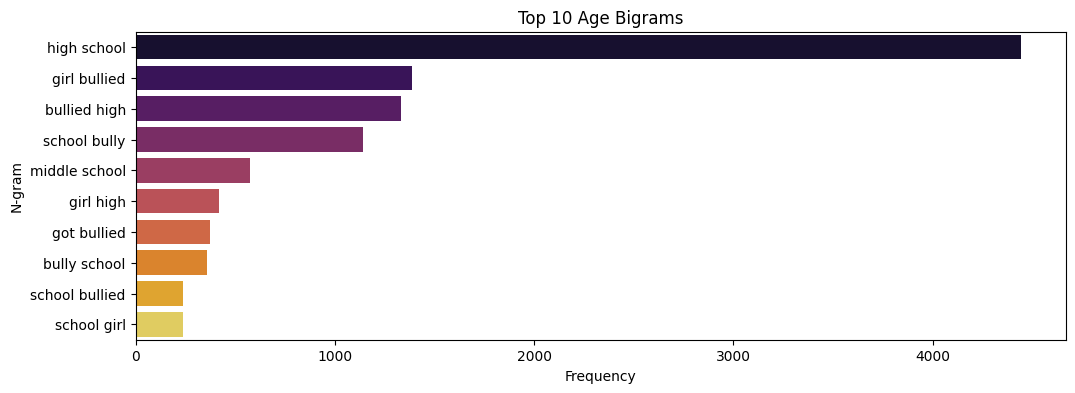

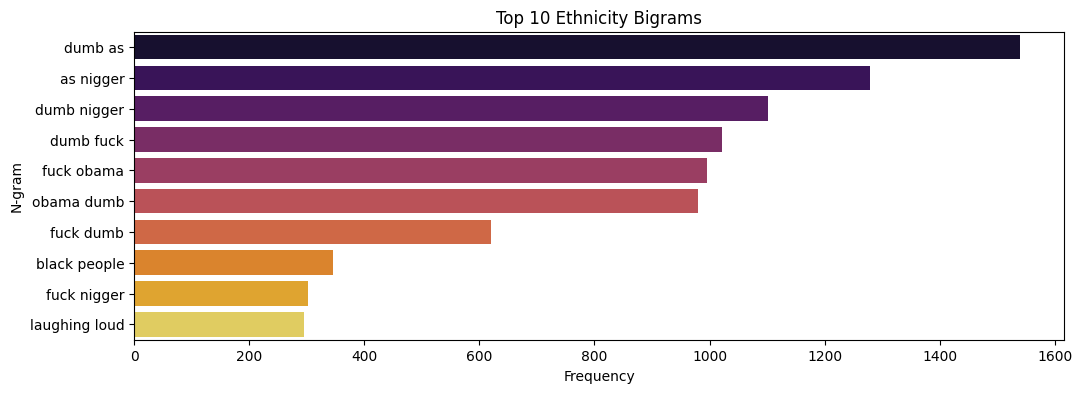

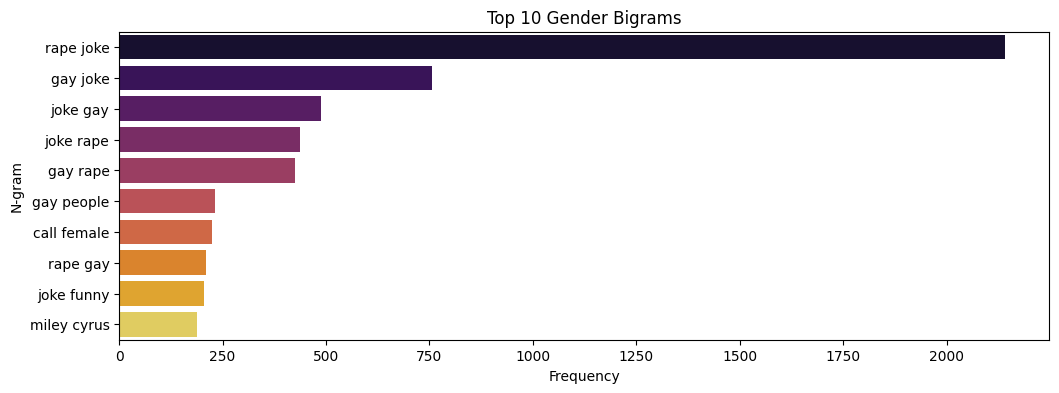

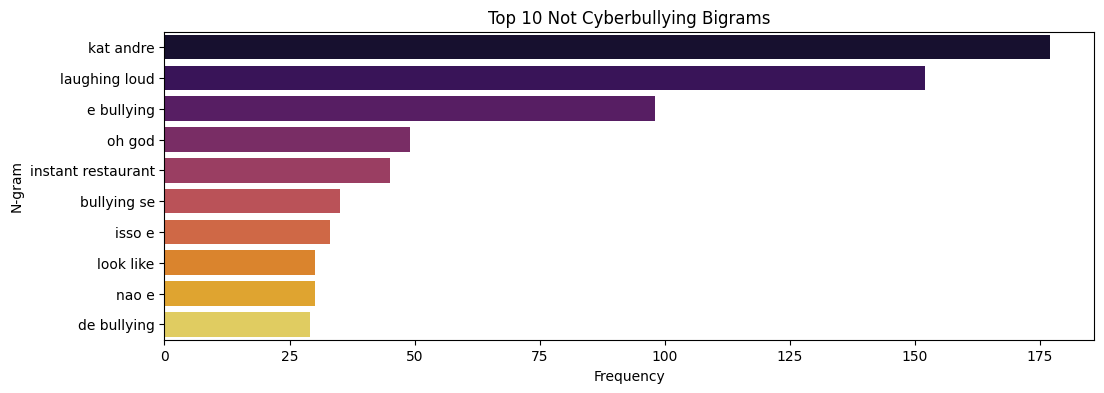

In [219]:
# Function to plot top n-grams
def plot_ngrams(ngrams_counter, title, num=10):
    ngram_df = pd.DataFrame(ngrams_counter.most_common(num), columns=['N-gram', 'Frequency'])
    
    plt.figure(figsize=(12, 4))
    sns.barplot(x='Frequency', y='N-gram', hue='N-gram', data=ngram_df, palette='inferno')
    plt.title(f'Top {num} {title}')
    plt.xlabel('Frequency')
    plt.ylabel('N-gram')
    plt.show()

# Plot the most common bigrams
plot_ngrams(religion_bigrams, title="Religion Bigrams")
plot_ngrams(age_bigrams, title="Age Bigrams")
plot_ngrams(ethnicity_bigrams, title="Ethnicity Bigrams")
plot_ngrams(gender_bigrams, title="Gender Bigrams")
plot_ngrams(not_cyberbullying_bigrams, title="Not Cyberbullying Bigrams")


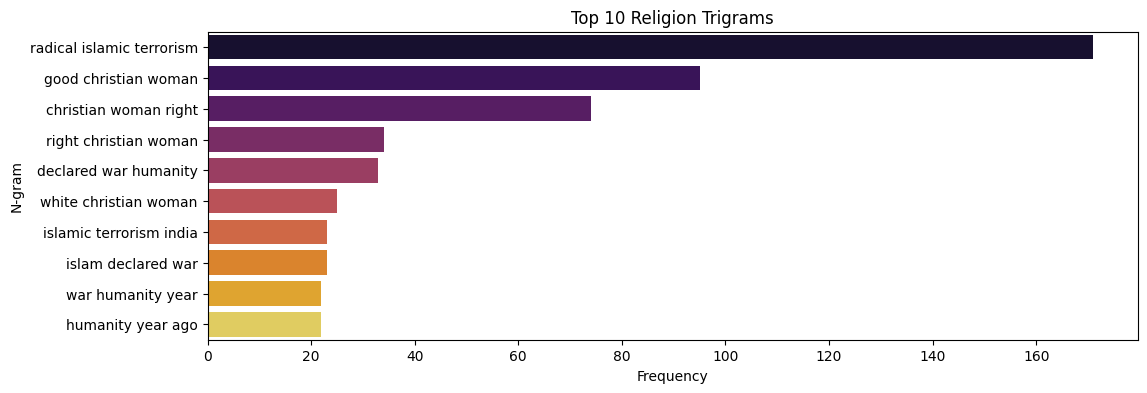

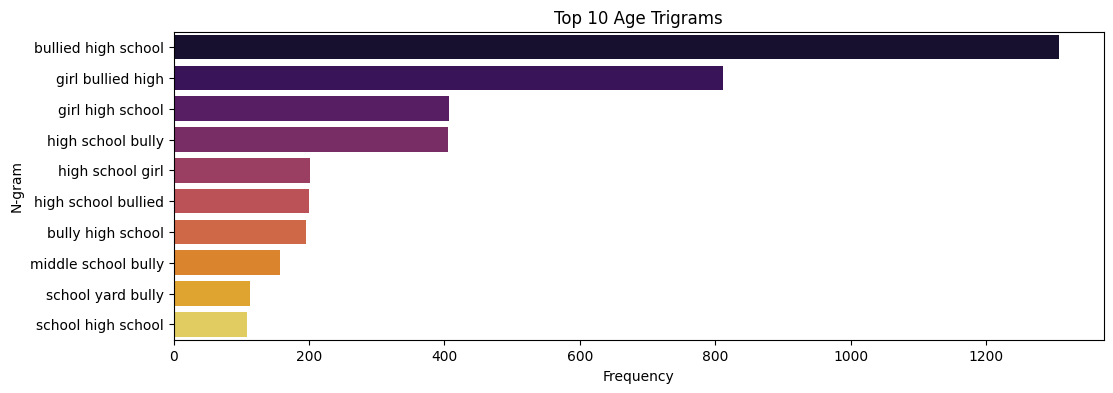

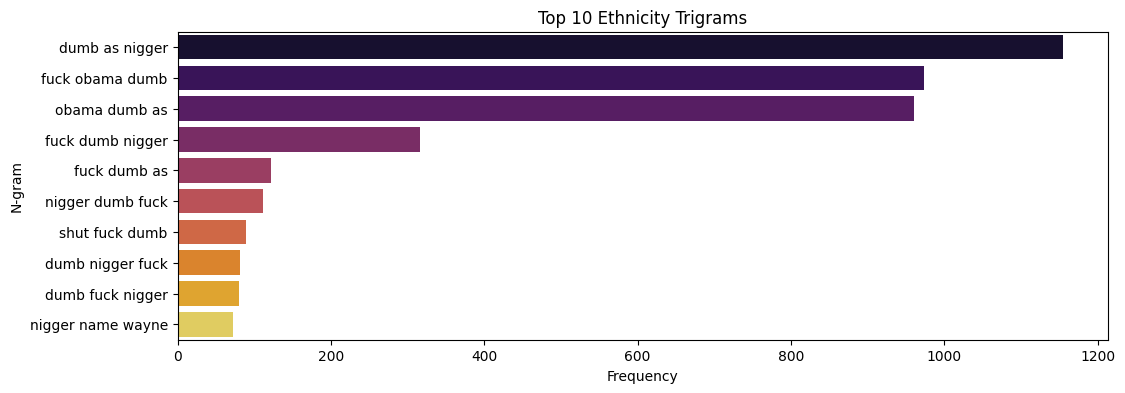

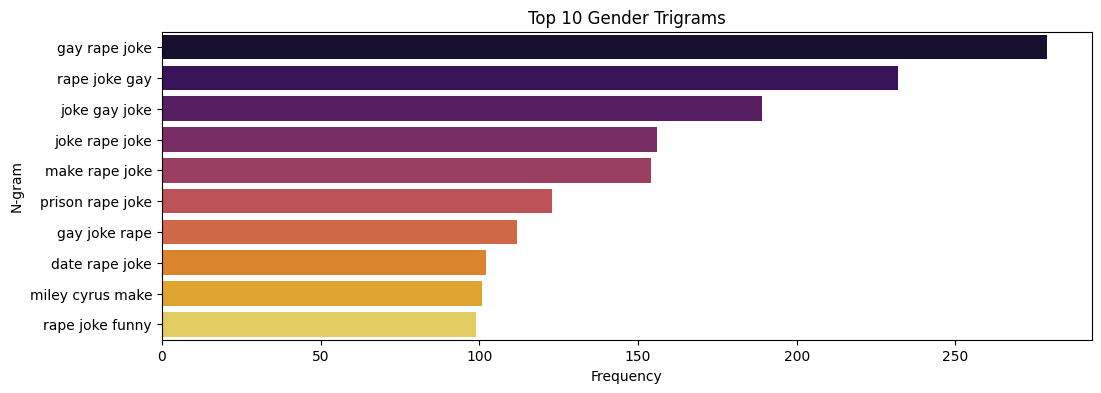

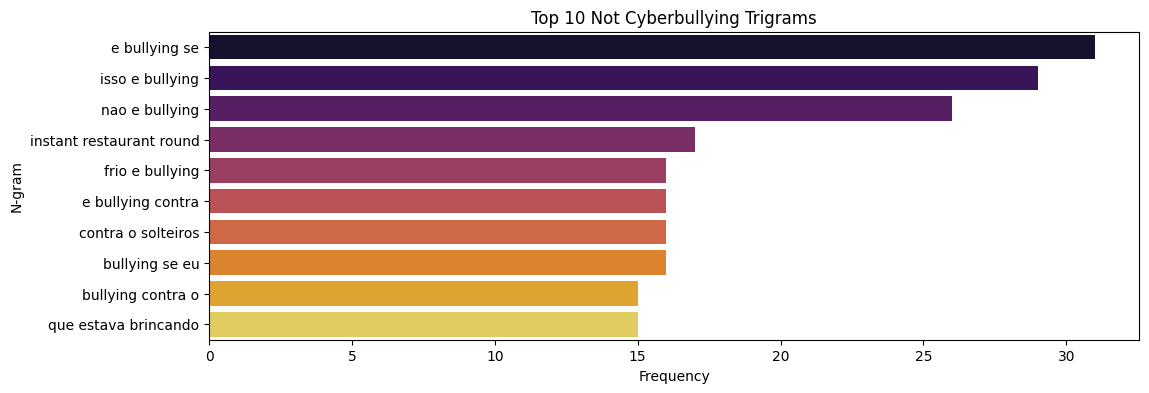

In [220]:
# Plot the most common trigrams
plot_ngrams(religion_trigrams, title="Religion Trigrams")
plot_ngrams(age_trigrams, title="Age Trigrams")
plot_ngrams(ethnicity_trigrams, title="Ethnicity Trigrams")
plot_ngrams(gender_trigrams, title="Gender Trigrams")
plot_ngrams(not_cyberbullying_trigrams, title="Not Cyberbullying Trigrams")

## Saving preprocessed columns into a new DataFrame

In [221]:
# Create a new DataFrame with preprocessed columns
df_cleaned = df[['text_cleaned', 'cyberbullying_type']]

In [222]:
df_cleaned.to_csv('../data/cleaned_data.csv', index=False)

## Conclusion

In our exploratory data analysis (EDA) and text cleaning process, we have explored and prepared the dataset for the cyberbullying classification task. Our analysis revealed significant insights into the distribution of tweet lengths, with a majority of tweets containing between 7 to 18 words, while a few outliers extended to hundreds of words. 

The raw tweet data contain several challenges, including slang, special characters, emojis, and inconsistencies like retweets (RT) and quoted tweets (QT). 

**Text Cleaning**:
For preparing the tweet data for analysis and further modelling, text cleaning process was applied for the removal of noise and irrelevant content while retaining the core message of each tweet. The following steps outline the text cleaning process:

1.  Lowercase Conversion: The input text is converted to lowercase to ensure uniformity, avoiding mismatches due to case sensitivity.
2. Contractions Expansion: Common contractions (e.g., "can't" -> "can not", "you're" -> "you are") are expanded using a predefined contractions dictionary to make the text more explicit.
3. Misspelled Words and Slang Correction: A predefined dictionary of common slang and misspellings (e.g., "u" -> "you", "plz" -> "please") is used to correct the text for better readability and standardization.
4. Remove Accented Characters: Accented characters are replaced with their non-accented counterparts (e.g., "café" -> "cafe") to avoid mismatches due to special characters.
5. Pattern Removal:
* Email Removal: Any email addresses are removed from the text.
* URL Removal: All URLs starting with http, www, or https are removed.
* Retweet and Quote Removal: "RT" and "QT" prefixes are removed.
* Mention Removal: User mentions (e.g., @username) are deleted.
* Hashtag Cleaning: Hashtags at the end of the text are removed, while hashtags within the text are stripped of the # symbol (e.g., #example -> example).
* Emoji and Emoticon Removal: Unicode-based emojis and traditional keyboard emoticons are removed from the text.
* Elongated Character Reduction: Repeated characters in words (e.g., "coooool" -> "cool") are reduced to two instances.
* Dot Removal: Consecutive dots (e.g., "..." or "..") are replaced with a space.
* Special Character and Number Removal: All non-alphabetic characters (except for whitespace) and numbers are removed.
* Whitespace Reduction: Extra spaces and spaces between single characters are removed.

6. Stopwords Removal:Common stopwords (e.g., "is", "and", "the") are removed from the text to retain only meaningful words.
7. Tokenization and Lemmatization: The text is tokenized (split into words), and each word is lemmatized (reduced to its base form, e.g., "running" -> "run") to standardize word forms.


There are lot of spelling mistakes in these tweets which is expected. It’s common to encounter a significant number of spelling mistakes in social media data like tweets. This can impact the accuracy of text-based models if not addressed.